# Dashboard
markdown-pdf is needed for PDF Report: https://www.npmjs.com/package/markdown-pdf

```npm install -g markdown-pdf```

## Setup

### Load common functions

In [1]:
from base_functions import *

### Load base functions

In [2]:
#from base_config import *

In [3]:
get_ipython().run_line_magic('load_ext', 'watermark')  # noqa
get_ipython().run_line_magic('watermark', '-a "Silvan Zahno" -d -v -iv -m -h')  # noqa

matplotlib 3.1.3
pandas     1.0.1
re         2.2.1
json       2.0.9
pytz       2019.3
plotly     4.5.4
watermark  2.0.2
numpy      1.18.1
seaborn    0.10.0
Silvan Zahno 2020-03-31 

CPython 3.7.6
IPython 7.12.0

compiler   : MSC v.1916 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 126 Stepping 5, GenuineIntel
CPU cores  : 8
interpreter: 64bit
host name  : zell


In [4]:
verbose = 2

### Configuration

In [5]:
# Setup local input directories
inputDir = data_inputDir + os.sep
createDir(inputDir)

In [6]:
# Setup local output directories
outputDir = data_outputDir + os.sep
md_subdir = "md" + os.sep
data_subdir = "data" + os.sep
graph_subdir = "graph" + os.sep
createDir(os.path.realpath(outputDir))
outputMdDir = outputDir + md_subdir
createDir(os.path.realpath(outputMdDir))
outputSubDir = outputDir + data_subdir
createDir(os.path.realpath(outputDir + data_subdir))
outputGraphDir = outputDir + md_subdir + graph_subdir
createDir(os.path.realpath(outputGraphDir))

## Data Import

### Read ProjectList  Data

In [7]:
projectList = pd.read_excel(projectListFile)
# Convert to datetime
projectList[projectListColumns[5]] =  pd.to_datetime(projectList[projectListColumns[5]], format='%d.%m.%Y')
projectList[projectListColumns[6]] =  pd.to_datetime(projectList[projectListColumns[6]], format='%d.%m.%Y')

# Calculate duration
projectList['duration'] = projectList[projectListColumns[6]] - projectList[projectListColumns[5]]
projectList['duration_month'] = year2month* (projectList[projectListColumns[6]].dt.year - projectList[projectListColumns[5]].dt.year) + (projectList[projectListColumns[6]].dt.month - projectList[projectListColumns[5]].dt.month + (projectList[projectListColumns[6]].dt.day - projectList[projectListColumns[5]].dt.day)*day2month)
projectListColumns.append('duration')
projectListColumns.append('duration_month')
if verbose >= 1:
  display(projectList)

,project_number,acronym,title_humanreadable,title,budget_total,budget_material,date_begin,date_end,duration,duration_month
0,102035,Formation ISI,Formation ISI,S20_Formation_ISI,NaN,NaN,NaT,NaT,NaT,NaN
1,100092,P3-USP,P3 - Unique Stability Plate,P3 - prime soutien Inno 2019 - USP,NaN,NaN,NaT,NaT,NaT,NaN
2,99904,P3-GAE,P3 - Groundbreaking Aluminium Extrusion,P3 - prime soutien Inno 2019 - Groundbreaking,NaN,NaN,NaT,NaT,NaT,NaN
3,99903,P3-DT,P3 - Dynamic Production Planning with Digital ...,P3 - prime soutein Inno 2019 - Dynamic,15000.0,NaN,2019-11-01,2020-12-18,413 days,13.558522
4,98568,DT,Dynamic Production Planning with Digital Twin,Impulse-Dynamic - Contrat No 35930.1 IP-ENG,312274.0,2020.0,2019-11-01,2020-10-31,365 days,11.985626
5,96201,USP,Unique Stability Plate,USP - Innosuisse No 35311.1 IP-ENG,NaN,NaN,NaT,NaT,NaT,NaN
6,95594,SPL-Filiere,SPL Filiere,Lab Smart Process CONSTELLIUM - Filière,NaN,NaN,NaT,NaT,NaT,NaN
7,95145,SPL-PPI,SPL Personal Development,Lab Smart Process CONSTELLIUM - PPI,NaN,NaN,NaT,NaT,NaT,NaN
8,89403,SPL-Base,SPL Base,Smart Process LAb CONSTELLIUM,NaN,NaN,NaT,NaT,NaT,NaN


### Read Project Data

In [8]:
dirlist = os.listdir(inputDir)
print("Files from directory ", inputDir)
for file in dirlist:
    print("  * ", file)

Files from directory  in\
  *  98568_de.xls
  *  98568_fr.xls
  *  99903.xls


In [9]:
sageXDfs = []
projectConfs = []

for file in dirlist:
  file = inputDir + os.sep + file

  # Get Project ID
  filename = os.path.basename(file)
  filename = os.path.splitext(filename)[0]
  projectId = re.search('([0-9]*)', filename).groups()[0]

  # Read Excel
  sageXDf = pd.read_excel(file)

  # Remove the last two Rows (Total and empty row)
  sageXDf.drop(sageXDf.tail(2).index,inplace=True)

  # Detect Language
  if sageXDf.columns[0] == ash_columns['german'][0]:
    lang = 'german'
  else:
    lang = 'french'

  # Convert Date to Datetime
  sageXDf[ash_columns[lang][0]] =  pd.to_datetime(sageXDf[ash_columns[lang][0]], format='%d.%m.%Y')

  # Display
  if verbose >= 2:
    print("Project Id: " +  projectId)
    print("Language: " + lang)
    display(sageXDf)
  
  sageXDfs.append(sageXDf)
  projectConfs.append([projectId, lang])

Project Id: 98568
Language: german


,Datum,Mitarbeiter,Tätigkeit,Zugeteilter Satz,Anz. Stunden,Betrag,Beschrieb
0,2019-11-11,Mottiez Gilles,Durchführung von aF&E Projekten oder -Arbeiten,63.9,32.50,2076.75,SDK and doc about ROS
1,2019-11-25,Mottiez Gilles,Durchführung von aF&E Projekten oder -Arbeiten,63.9,68.66,4387.80,ROS driver and sensors
2,2019-11-28,Fracheboud Loïc,Durchführung von aF&E Projekten oder -Arbeiten,63.9,106.00,6773.40,NaN
3,2019-11-30,Corre Jérôme,Arbeitssitzung,112.1,11.25,1261.12,NaN
4,2019-11-30,Corre Jérôme,Durchführung von aF&E Projekten oder -Arbeiten,112.1,15.00,1681.50,NaN
5,2019-11-30,Zahno Silvan,Durchführung von Mandaten,133.4,29.50,3935.30,working on USP Project
6,2019-12-18,Fracheboud Loïc,Durchführung von aF&E Projekten oder -Arbeiten,63.9,15.50,990.45,NaN
7,2019-12-19,Mottiez Gilles,Durchführung von aF&E Projekten oder -Arbeiten,63.9,57.50,3674.25,NaN
8,2019-12-31,Corre Jérôme,Durchführung von aF&E Projekten oder -Arbeiten,112.1,15.00,1681.50,NaN
9,2019-12-31,Corre Jérôme,Arbeitssitzung,112.1,2.00,224.20,NaN


Project Id: 98568
Language: french


,Date,Collaborateur,Activité,Taux affecté,Nb heures,Montant,Description
0,2019-11-11,Mottiez Gilles,Réalisation de projets ou d'activités Ra&D,63.9,32.50,2076.75,SDK and doc about ROS
1,2019-11-25,Mottiez Gilles,Réalisation de projets ou d'activités Ra&D,63.9,68.66,4387.80,ROS driver and sensors
2,2019-11-28,Fracheboud Loïc,Réalisation de projets ou d'activités Ra&D,63.9,106.00,6773.40,NaN
3,2019-11-30,Corre Jérôme,Séance de travail,112.1,11.25,1261.12,NaN
4,2019-11-30,Corre Jérôme,Réalisation de projets ou d'activités Ra&D,112.1,15.00,1681.50,NaN
5,2019-11-30,Zahno Silvan,Réalisation de mandats,133.4,29.50,3935.30,working on USP Project
6,2019-12-18,Fracheboud Loïc,Réalisation de projets ou d'activités Ra&D,63.9,15.50,990.45,NaN
7,2019-12-19,Mottiez Gilles,Réalisation de projets ou d'activités Ra&D,63.9,57.50,3674.25,NaN
8,2019-12-31,Corre Jérôme,Réalisation de projets ou d'activités Ra&D,112.1,15.00,1681.50,NaN
9,2019-12-31,Corre Jérôme,Séance de travail,112.1,2.00,224.20,NaN


Project Id: 99903
Language: german


,Datum,Mitarbeiter,Tätigkeit,Zugeteilter Satz,Anz. Stunden,Betrag,Beschrieb
0,2020-02-29,Zahno Silvan,Durchführung von aF&E Projekten oder -Arbeiten,80.0,15.25,1220.0,DT Projekt durchführung


## Aggregate Time
* aggregated1Df = Sum by activity and person
* aggregated2Df = Sum by person
* aggregated3Df = Sum by Month

In [10]:
aggregated1Dfs = []
aggregated2Dfs = []
aggregated3Dfs = []

for i in range(len(projectConfs)):
  ash_col = ash_columns[projectConfs[i][1]]
  aggregated1Df = (sageXDfs[i].groupby([ash_col[1],ash_columns[projectConfs[i][1]][2]], as_index=False).agg({ash_col[3]:"first", ash_col[4]:"sum", ash_col[5]:"sum"}))
  aggregated2Df = (sageXDfs[i].groupby([ash_col[1]], as_index=False).agg({ash_col[3]:"first", ash_col[4]:"sum", ash_col[5]:"sum"}))
  if len(sageXDfs[i].axes[0]) > 1:
    # Set date as index
    aggregated3Df = sageXDfs[i].set_index(ash_col[0])
    # group by collaborator
    aggregated3Df = aggregated3Df.groupby(ash_col[1], as_index=False)
    # group group antries by month
    aggregated3Df = aggregated3Df.resample("M")
    # define aggregation
    aggregated3Df = aggregated3Df.agg({ash_col[1]:"first", ash_col[3]:"first", ash_col[4]:"sum", ash_col[5]:"sum"})
    # reset index
    aggregated3Df = aggregated3Df.reset_index(0, drop=True).reset_index()
    # remove day from datetime
    #aggregated3Df[ash_col[0]] =  aggregated3Df[ash_col[0]].apply(lambda x: x.strftime('%Y-%m'))
  else:
    aggregated3Df = sageXDfs[i]
    aggregated3Df = removeColumns(aggregated3Df, [ash_col[2]], verbose=False)
    # remove day from datetime
    #aggregated3Df[ash_col[0]] =  aggregated3Df[ash_col[0]].apply(lambda x: x.strftime('%Y-%m'))
  # sort by date
  aggregated3Df = aggregated3Df.sort_values(by=ash_columns[projectConfs[i][1]][0])
  
  # Display Results
  if verbose >= 1:
    print("-------------------------------------------------------------------------")
    display(filterRows(projectList, [projectListColumns[0], [projectConfs[i][0]]]))
    print("Aggregated 1")
    display(aggregated1Df)
    print("Aggregated 2")
    display(aggregated2Df)
    print("Aggregated 3")
    display(aggregated3Df)
    
  aggregated1Dfs.append(aggregated1Df)
  aggregated2Dfs.append(aggregated2Df)
  aggregated3Dfs.append(aggregated3Df)

-------------------------------------------------------------------------


,project_number,acronym,title_humanreadable,title,budget_total,budget_material,date_begin,date_end,duration,duration_month
4,98568,DT,Dynamic Production Planning with Digital Twin,Impulse-Dynamic - Contrat No 35930.1 IP-ENG,312274.0,2020.0,2019-11-01,2020-10-31,365 days,11.985626


Aggregated 1


,Mitarbeiter,Tätigkeit,Zugeteilter Satz,Anz. Stunden,Betrag
0,Berthouzoz David,Durchführung von Mandaten,69.5,0.50,34.75
1,Corre Jérôme,Arbeitssitzung,112.1,15.75,1765.57
2,Corre Jérôme,Durchführung von aF&E Projekten oder -Arbeiten,112.1,58.66,6576.52
3,Fracheboud Loïc,Durchführung von aF&E Projekten oder -Arbeiten,63.9,336.33,21491.69
4,Mottiez Gilles,Durchführung von aF&E Projekten oder -Arbeiten,63.9,326.07,20836.72
5,Zahno Silvan,Durchführung von Mandaten,133.4,36.50,4869.10
6,Zahno Silvan,Durchführung von aF&E Projekten oder -Arbeiten,133.4,16.50,2201.10


Aggregated 2


,Mitarbeiter,Zugeteilter Satz,Anz. Stunden,Betrag
0,Berthouzoz David,69.5,0.50,34.75
1,Corre Jérôme,112.1,74.41,8342.09
2,Fracheboud Loïc,63.9,336.33,21491.69
3,Mottiez Gilles,63.9,326.07,20836.72
4,Zahno Silvan,133.4,53.00,7070.20


Aggregated 3


,Datum,Mitarbeiter,Zugeteilter Satz,Anz. Stunden,Betrag
1,2019-11-30,Corre Jérôme,112.1,26.25,2942.62
5,2019-11-30,Fracheboud Loïc,63.9,106.00,6773.40
9,2019-11-30,Mottiez Gilles,63.9,101.16,6464.55
13,2019-11-30,Zahno Silvan,133.4,29.50,3935.30
2,2019-12-31,Corre Jérôme,112.1,17.00,1905.70
6,2019-12-31,Fracheboud Loïc,63.9,15.50,990.45
10,2019-12-31,Mottiez Gilles,63.9,57.50,3674.25
14,2019-12-31,Zahno Silvan,133.4,7.00,933.80
0,2020-01-31,Berthouzoz David,69.5,0.50,34.75
3,2020-01-31,Corre Jérôme,112.1,21.41,2400.80


-------------------------------------------------------------------------


,project_number,acronym,title_humanreadable,title,budget_total,budget_material,date_begin,date_end,duration,duration_month
4,98568,DT,Dynamic Production Planning with Digital Twin,Impulse-Dynamic - Contrat No 35930.1 IP-ENG,312274.0,2020.0,2019-11-01,2020-10-31,365 days,11.985626


Aggregated 1


,Collaborateur,Activité,Taux affecté,Nb heures,Montant
0,Berthouzoz David,Réalisation de mandats,69.5,0.50,34.75
1,Corre Jérôme,Réalisation de projets ou d'activités Ra&D,112.1,58.66,6576.52
2,Corre Jérôme,Séance de travail,112.1,15.75,1765.57
3,Fracheboud Loïc,Réalisation de projets ou d'activités Ra&D,63.9,336.33,21491.69
4,Mottiez Gilles,Réalisation de projets ou d'activités Ra&D,63.9,326.07,20836.72
5,Zahno Silvan,Réalisation de mandats,133.4,36.50,4869.10
6,Zahno Silvan,Réalisation de projets ou d'activités Ra&D,133.4,16.50,2201.10


Aggregated 2


,Collaborateur,Taux affecté,Nb heures,Montant
0,Berthouzoz David,69.5,0.50,34.75
1,Corre Jérôme,112.1,74.41,8342.09
2,Fracheboud Loïc,63.9,336.33,21491.69
3,Mottiez Gilles,63.9,326.07,20836.72
4,Zahno Silvan,133.4,53.00,7070.20


Aggregated 3


,Date,Collaborateur,Taux affecté,Nb heures,Montant
1,2019-11-30,Corre Jérôme,112.1,26.25,2942.62
5,2019-11-30,Fracheboud Loïc,63.9,106.00,6773.40
9,2019-11-30,Mottiez Gilles,63.9,101.16,6464.55
13,2019-11-30,Zahno Silvan,133.4,29.50,3935.30
2,2019-12-31,Corre Jérôme,112.1,17.00,1905.70
6,2019-12-31,Fracheboud Loïc,63.9,15.50,990.45
10,2019-12-31,Mottiez Gilles,63.9,57.50,3674.25
14,2019-12-31,Zahno Silvan,133.4,7.00,933.80
0,2020-01-31,Berthouzoz David,69.5,0.50,34.75
3,2020-01-31,Corre Jérôme,112.1,21.41,2400.80


-------------------------------------------------------------------------


,project_number,acronym,title_humanreadable,title,budget_total,budget_material,date_begin,date_end,duration,duration_month
3,99903,P3-DT,P3 - Dynamic Production Planning with Digital ...,P3 - prime soutein Inno 2019 - Dynamic,15000.0,NaN,2019-11-01,2020-12-18,413 days,13.558522


Aggregated 1


,Mitarbeiter,Tätigkeit,Zugeteilter Satz,Anz. Stunden,Betrag
0,Zahno Silvan,Durchführung von aF&E Projekten oder -Arbeiten,80.0,15.25,1220.0


Aggregated 2


,Mitarbeiter,Zugeteilter Satz,Anz. Stunden,Betrag
0,Zahno Silvan,80.0,15.25,1220.0


Aggregated 3


,Datum,Mitarbeiter,Zugeteilter Satz,Anz. Stunden,Betrag,Beschrieb
0,2020-02-29,Zahno Silvan,80.0,15.25,1220.0,DT Projekt durchführung


## Calculations

### Add Total and Remaining Budget

In [11]:
def calc_remainingBudget_int(cost):
    global remaining_budget
    remaining_budget = remaining_budget - cost
    return remaining_budget

dfs = aggregated3Dfs
for i in range(len(projectConfs)):
  projectConf = projectConfs[i]
  df = dfs[i]
  ash_col = ash_columns[projectConf[1]]
  ash_columns[projectConf[1]].append('Total Budget')
  df['Total Budget'] = filterRows(projectList, [projectListColumns[0], [projectConf[0]]])[projectListColumns[3]].iloc[0]
  monthly_budget = df['Total Budget'].iloc[0]/filterRows(projectList, [projectListColumns[0], [projectConf[0]]])[projectListColumns[8]].iloc[0]
  
  ash_columns[projectConf[1]].append('Monthy Budget')
  df['Monthy Budget'] = monthly_budget
  
  ash_columns[projectConf[1]].append('Remaining Budget')
  remaining_budget = df['Total Budget'].iloc[0]
  df['Remaining Budget'] = df.apply(lambda x: calc_remainingBudget_int(x[ash_col[5]]), axis=1)
  #df['Remaining Budget'].loc[0] = df['Total Budget'].iloc[0]
  
  display(df)

,Datum,Mitarbeiter,Zugeteilter Satz,Anz. Stunden,Betrag,Total Budget,Monthy Budget,Remaining Budget
1,2019-11-30,Corre Jérôme,112.1,26.25,2942.62,312274.0,26054.041081,309331.38
5,2019-11-30,Fracheboud Loïc,63.9,106.00,6773.40,312274.0,26054.041081,302557.98
9,2019-11-30,Mottiez Gilles,63.9,101.16,6464.55,312274.0,26054.041081,296093.43
13,2019-11-30,Zahno Silvan,133.4,29.50,3935.30,312274.0,26054.041081,292158.13
2,2019-12-31,Corre Jérôme,112.1,17.00,1905.70,312274.0,26054.041081,290252.43
6,2019-12-31,Fracheboud Loïc,63.9,15.50,990.45,312274.0,26054.041081,289261.98
10,2019-12-31,Mottiez Gilles,63.9,57.50,3674.25,312274.0,26054.041081,285587.73
14,2019-12-31,Zahno Silvan,133.4,7.00,933.80,312274.0,26054.041081,284653.93
0,2020-01-31,Berthouzoz David,69.5,0.50,34.75,312274.0,26054.041081,284619.18
3,2020-01-31,Corre Jérôme,112.1,21.41,2400.80,312274.0,26054.041081,282218.38


,Date,Collaborateur,Taux affecté,Nb heures,Montant,Total Budget,Monthy Budget,Remaining Budget
1,2019-11-30,Corre Jérôme,112.1,26.25,2942.62,312274.0,26054.041081,309331.38
5,2019-11-30,Fracheboud Loïc,63.9,106.00,6773.40,312274.0,26054.041081,302557.98
9,2019-11-30,Mottiez Gilles,63.9,101.16,6464.55,312274.0,26054.041081,296093.43
13,2019-11-30,Zahno Silvan,133.4,29.50,3935.30,312274.0,26054.041081,292158.13
2,2019-12-31,Corre Jérôme,112.1,17.00,1905.70,312274.0,26054.041081,290252.43
6,2019-12-31,Fracheboud Loïc,63.9,15.50,990.45,312274.0,26054.041081,289261.98
10,2019-12-31,Mottiez Gilles,63.9,57.50,3674.25,312274.0,26054.041081,285587.73
14,2019-12-31,Zahno Silvan,133.4,7.00,933.80,312274.0,26054.041081,284653.93
0,2020-01-31,Berthouzoz David,69.5,0.50,34.75,312274.0,26054.041081,284619.18
3,2020-01-31,Corre Jérôme,112.1,21.41,2400.80,312274.0,26054.041081,282218.38


,Datum,Mitarbeiter,Zugeteilter Satz,Anz. Stunden,Betrag,Beschrieb,Total Budget,Monthy Budget,Remaining Budget
0,2020-02-29,Zahno Silvan,80.0,15.25,1220.0,DT Projekt durchführung,15000.0,1106.31531,13780.0


## Analysis

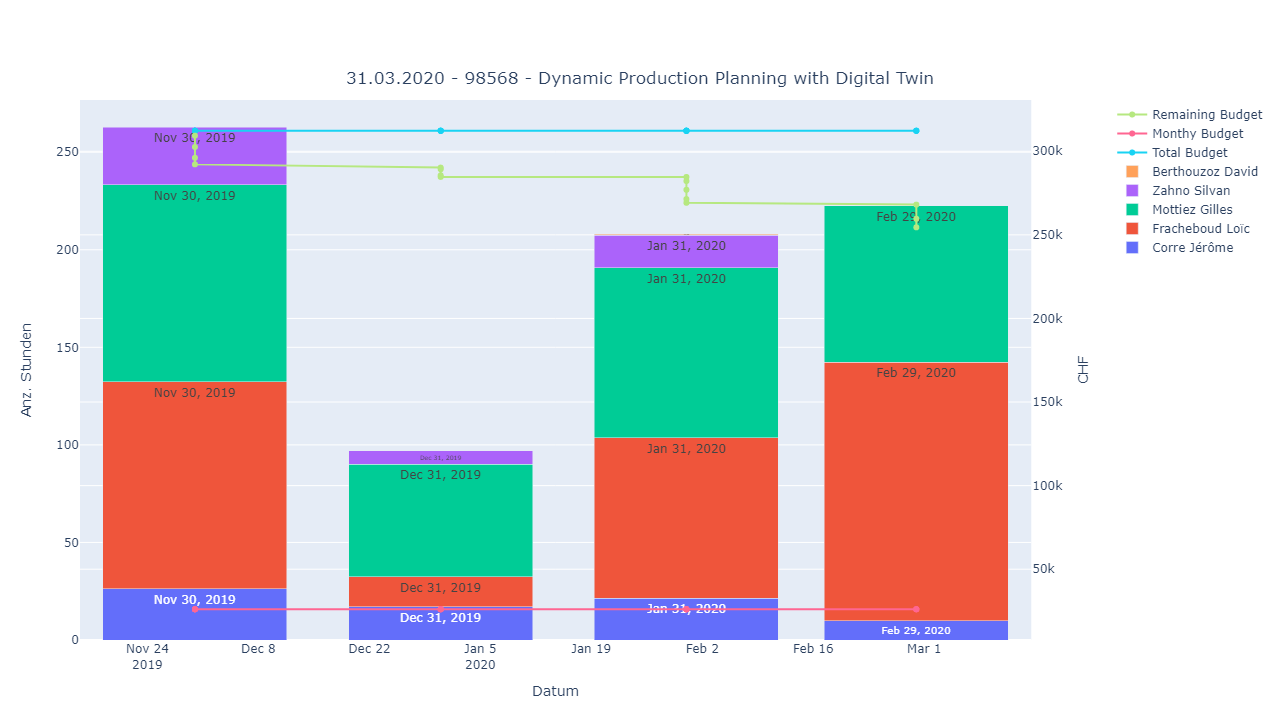

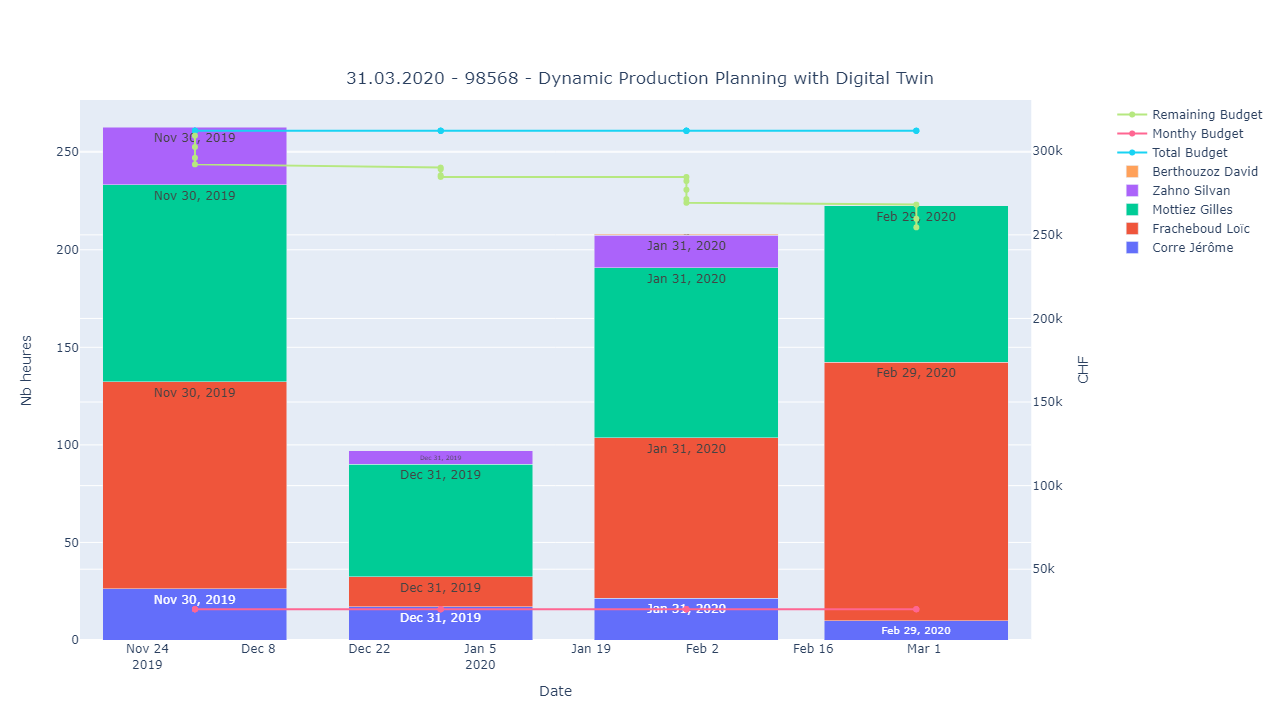

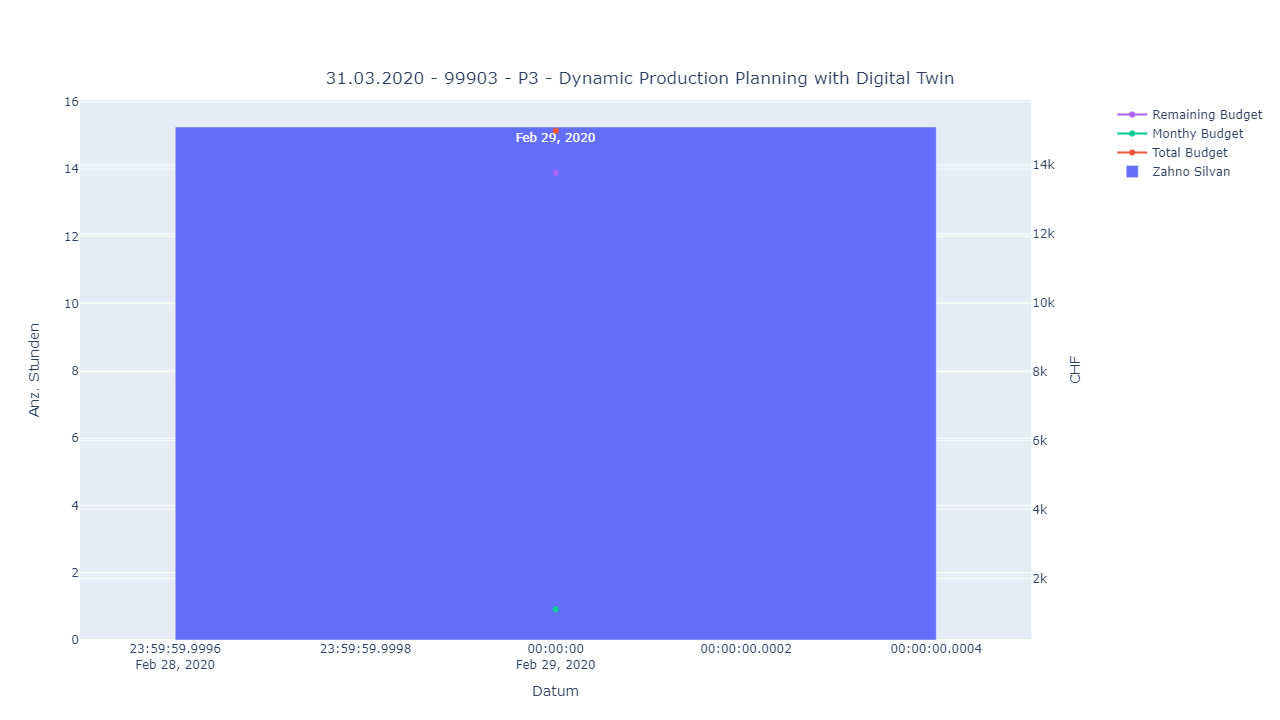

In [12]:
dfs = aggregated3Dfs
for i in range(len(projectConfs)):
  projectConf = projectConfs[i]
  df = dfs[i]
  ash_col = ash_columns[projectConfs[i][1]]
  stacked_bar_plot(df, ash_col, projectList, projectListColumns, projectConf, outputGraphDir, ext_file)